In [19]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [20]:
START_DATE = date(2000, 1, 1)
END_DATE = date(2022, 12, 31)

In [28]:
def read_yahoo_csv(filepath):
    df = pd.read_csv(filepath)[["Date", "Adj Close"]]
    df["Date"] = pd.to_datetime(df["Date"])
    df.rename(columns = {"Adj Close": os.path.basename(filepath).split(".")[0]}, inplace = True)
    return df

def read_yahoo_folder(folderpath, start, end):
    df = pd.DataFrame({'Date': pd.date_range(start, end, freq = 'D')})

    with os.scandir(folderpath) as entries:
        for entry in entries:
            df = df.merge(read_yahoo_csv(entry), on = "Date", how = "left")

    return df

Data downloaded manually from the Yahoo Finance website.

In [29]:
etf_df = read_yahoo_folder("data/etfs/", START_DATE, END_DATE)
exchange_rates_df = read_yahoo_folder("data/exchange-rates/", START_DATE, END_DATE)

<AxesSubplot: >

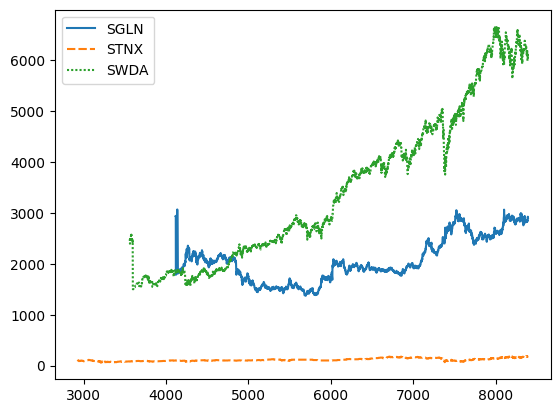

In [27]:
sns.lineplot(data = etf_df)

This is not very useful yet. Let's remove rows where the data is not full, so that all series start from the same point in time.

In [15]:
etf_df.dropna(inplace = True)

if "Date" in etf_df.columns:
    etf_df.set_index("Date", inplace = True)

 Also, let's standarise the output, to make it easier to see differences in value. Before we do that, let's write down the latest prices.

In [ ]:
latest_prices = get_latest_prices(etf_df)

etf_df = etf_df.div(etf_df.iloc[0])

In [ ]:
etf_df

,SGLN,STNX,SWDA
Date,,,
2011-04-08,1.000000,1.000000,1.000000
2011-04-11,0.998955,0.996771,1.001624
2011-04-12,0.607680,0.961444,0.993774
2011-04-13,0.609629,0.967316,0.998105
2011-04-14,0.611756,0.961934,0.989442
...,...,...,...
2022-12-19,0.973977,1.742049,3.244721
2022-12-20,0.991841,1.733633,3.246887
2022-12-21,0.996264,1.767296,3.312398


[Text(0.5, 1.0, 'Portfolio Adj. Close Price History'),
 Text(0, 0.5, 'Adj. Close Price (USD)')]

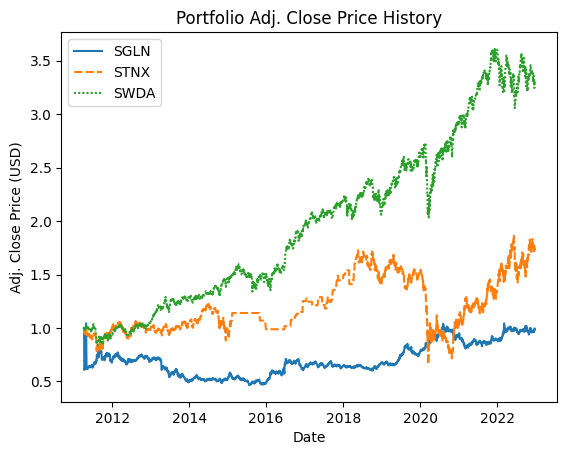

In [ ]:
sns.lineplot(data = etf_df).set(title = 'Portfolio Adj. Close Price History', ylabel = 'Adj. Close Price (USD)')

In [ ]:
#Show the daily simple return
returns = etf_df.pct_change()
returns

,SGLN,STNX,SWDA
Date,,,
2011-04-08,NaN,NaN,NaN
2011-04-11,-0.001045,-0.003229,0.001624
2011-04-12,-0.391685,-0.035441,-0.007838
2011-04-13,0.003208,0.006107,0.004358
2011-04-14,0.003489,-0.005564,-0.008679
...,...,...,...
2022-12-19,-0.001570,0.024281,-0.004485
2022-12-20,0.018341,-0.004831,0.000667
2022-12-21,0.004460,0.019417,0.020177


In [ ]:
#Create and show the annualized covariance matrix
cov_matrix_annual = returns.cov() * 252
cov_matrix_annual

,SGLN,STNX,SWDA
SGLN,0.092438,0.000774,0.001314
STNX,0.000774,0.061107,0.015903
SWDA,0.001314,0.015903,0.024047


In [ ]:
#Assign weights to the stocks
weights = np.array([.5, .25, .25])

In [ ]:
#Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.03094127906737811

In [ ]:
# Calculate the portfolio volatility (aka standard deviation)
port_volatility = np.sqrt(port_variance)
port_volatility

0.17590133333030228

In [ ]:
# Calculate the annual portfolio return
portfolioSimpleAnnualReturn = np.sum(returns.mean() * weights) * 252
portfolioSimpleAnnualReturn

0.07194026029371728

In [ ]:
#Show the expected annual return, volatility (aka risk), and variance

percent_var = str(round(port_variance, 2) * 100) + "%"
percent_vols = str(round(port_volatility, 2) * 100) + "%"
percent_ret = str(round(portfolioSimpleAnnualReturn, 2) * 100) + "%" 

print("Expected annual return: " + percent_ret)
print("Annual volatility (risk): " + percent_vols)
print("Annual variance: " + percent_var)

Expected annual return: 7.000000000000001%
Annual volatility (risk): 18.0%
Annual variance: 3.0%


In [ ]:
# Portfolio optimisation

# Calculate the expected returns and the annualised sample covariance matrix of asset returns
mu = expected_returns.mean_historical_return(etf_df)
S = risk_models.sample_cov(etf_df)

# Optimize for max Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)

OrderedDict([('SGLN', 0.0), ('STNX', 0.0), ('SWDA', 1.0)])
Expected annual return: 11.1%
Annual volatility: 15.5%
Sharpe Ratio: 0.59


(0.11093818842094283, 0.15507076804187245, 0.5864302445215693)

In [ ]:
# Get the discrete allocation of each share per stock
weights = cleaned_weights

da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)

allocation, leftover = da.lp_portfolio()
print("Discrete Allocation: ", allocation)
print("Funds Remaining:  ${:.2f}".format(leftover))

Discrete Allocation:  {'STNX': 11, 'SWDA': 1}
Funds Remaining:  $1938.22
